# Neural integration for constitutive equations 

### Benchmark #1: elasto-plastic material

Authors: Filippo Masi, Itai Einav

### 1. Import libraries

In [1]:
import pickle
import numpy as np
import torch
from scipy.optimize import root
from torchdiffeq import odeint
from nice_module import NICE, EarlyStopping, shuffle, slice_data, GetParams

np.random.seed(6)
torch.manual_seed(6)

# plotting
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('classic')
plt.rcParams.update({"axes.grid" : False, "grid.color": 'black', "grid.alpha":0.4})
font = {'size'   : 11}
matplotlib.rc('font', **font)
plt.rcParams['axes.facecolor']='none'
plt.rcParams['savefig.facecolor']='none'
plt.rcParams['figure.facecolor']='none'
plt.rcParams["figure.figsize"] = (2.5,2)
plt.tight_layout(pad=2.5, w_pad=3.5, h_pad=3.5)
colorb = (0.2,0.4,0.7)

<Figure size 200x160 with 0 Axes>

#### 1.1 Set hyperparameters

In [2]:
verbose_frequency = 100 # frequency in epochs for printing loss at training
step_size = 1 # to reproduce training process set = 20, else 1 (for fast training)
device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')
corrupted_training_data = False # boolean for adding normally distributed noise to training data set
delta = 0. # if corrupted_training_data = True, set noise amplitude (percentage)

### 2. Import and prepare data sets

In [3]:
file = './dataset/benchmark1_data_training'
with open(file, 'rb') as f_obj:
    data = pickle.load(f_obj)

[stress_t,strain_t,svars_e_t,svars_p_t,
 stress_tdt,strain_tdt,svars_e_tdt,svars_p_tdt,en_tdt,diss__,dt,n_reset]= data
batch_time = n_reset
data_size=n_reset

dim = 2
prm_dt = 1/data_size

#### 3.1 Reshape 


In [11]:
dstrain = strain_tdt - strain_t
dstrain/=prm_dt

strain_t = np.reshape(strain_t,(batch_time,-1,dim),order='F')
strain_tdt = np.reshape(strain_tdt,(batch_time,-1,dim),order='F')
dstrain = np.reshape(dstrain,(batch_time,-1,dim),order='F')

stress_t = np.reshape(stress_t,(batch_time,-1,dim),order='F')
stress_tdt = np.reshape(stress_tdt,(batch_time,-1,dim),order='F')
# dstress = np.reshape(dstress,(batch_time,-1,dim),order='F')

data_size = strain_t.shape[0]
number_IC = strain_t.shape[1]

#### 3.2 Split data in training, validation, and test sets 

In [12]:
train_percentage = .65

train = int(round(number_IC * train_percentage))
val = int(round(number_IC * 0.5 *(1.- train_percentage)))
test = val

print("Number of samples: ", number_IC)
print("Training samples : ", train)
print("Validation samples : ", val)
print("Test samples : ", test)
print("Total : ", test + val + train)

Number of samples:  24
Training samples :  16
Validation samples :  4
Test samples :  4
Total :  24


In [13]:
n = np.arange(0,number_IC,1)
rnd = np.arange(len(n))
np.random.shuffle(rnd)
n = n[rnd]
ntrain = n[:train]
cut = len(ntrain)
nval = n[train:]
ntrainval = np.hstack((ntrain,nval))
ntest = n[train+val:]

rnd = np.arange(len(ntrainval))
ntrain = rnd[:train]
nval = rnd[val:]

In [14]:
strain_t_tv,strain_t_test = slice_data(strain_t,ntrainval,ntest)
strain_tdt_tv,strain_tdt_test = slice_data(strain_tdt,ntrainval,ntest)
dstrain_tv,dstrain_test = slice_data(dstrain,ntrainval,ntest)
stress_t_tv,stress_t_test = slice_data(stress_t,ntrainval,ntest)

In [15]:
if corrupted_training_data:
    # Stress noise vector
    noise = delta/100 * np.random.normal(0,1,((data_size+1,number_IC,dim)))
    # Corrupt stress with noise
    noise_stress_t = stress_t_tv.copy()
    noise_stress_t[:,:,0] = np.mean(stress_t_tv[:,:,0])*noise[:-1,:,0]
    noise_stress_t[:,:,1] = np.mean(stress_t_tv[:,:,1])*noise[:-1,:,1]
    noise_stress_t[0] *= 0.0
    stress_t_tv += noise_stress_t

In [16]:
prm_e = GetParams(strain_t_tv).to(device)
prm_de = GetParams(dstrain_tv).to(device)
prm_s = GetParams(stress_t_tv).to(device)

### 4. Neural integration for constitutive equations

#### 4.1 Constructu neural net and set integration scheme

In [13]:
dtype=torch.float64
hidden_num = 0
NNf_params = [2*dim,dim,[6*(2*dim),6*(2*dim),6*(2*dim),],'gelu']
NNu_params = [2,1,[2**6,2**6],'softplus']
norm_params = [prm_e,prm_de,prm_s,prm_dt]
nsvars = 1
NICE_network = NICE(NNf_params,NNu_params,hidden_num,number_IC,norm_params,dim,nsvars,dtype).to(device)
NICE_network.to(torch.double)

NICE(
  (NeuralNetEvolution): Sequential(
    (0): Linear(in_features=4, out_features=24, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=24, out_features=24, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=24, out_features=24, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=24, out_features=2, bias=True)
  )
  (NeuralNetEnergy): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Softplus(beta=1, threshold=20)
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
  (relu): ReLU()
)

In [14]:
prm_dt = 1/data_size
t = torch.arange(0,1.0,prm_dt)
stress_tv = torch.from_numpy(np.float64(stress_t_tv)).to(device)
dstrain_tv = torch.from_numpy(np.float64(dstrain_tv)).to(device)
stress_test = torch.from_numpy(np.float64(stress_t_test)).to(device)
dstrain_test = torch.from_numpy(np.float64(dstrain_test)).to(device)

In [15]:
NICE_network.solver = "midpoint"
NICE_network.scheme = "forward"
NICE_network.step_size = prm_dt/step_size
NICE_network.init_interp(dstrain_tv,t)
NICE_network.inference = False

#### 4.2 Training

In [16]:
# Optimizer, loss function, and hyperparameters
learningRate = 1e-2
optimizer =  torch.optim.Adam(NICE_network.parameters(),lr=learningRate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.999)
w_reg = 1.e-5 # l2 penalty weight 
Nepochs = 1000000 # number of epochs
MSE = torch.nn.MSELoss()

# Early stopping criterion
checkpoint_path = 'checkpoint.pt'
early_stopping = EarlyStopping(patience=1000, delta=1.e-9, verbose=False, path=checkpoint_path)

# List for storing training and validation loss
training_loss_hist = []
validation_loss_value_hist = []

In [17]:
for epoch in range(1,Nepochs):
    optimizer.zero_grad()
    # Compute residual of the initial stress value based on the initial elastic strain value (hyperparameter)
    ueps_e_0 = NICE_network.DeNormalize(NICE_network.e0,NICE_network.prm_ee)
    stress0 = NICE_network.stress(ueps_e_0)
    
    # Make predictions
    pred_svars,pred_stress,pred_diss = NICE_network.integrate(dstrain_tv, ueps_e_0, t, np.hstack((ntrain,nval)))
    # Compute training loss
    training_loss_stress = MSE(NICE_network.Normalize(pred_stress[:,ntrain],prm_s),
                               NICE_network.Normalize(stress_tv[:,ntrain],prm_s))
    training_loss_r0 = MSE(NICE_network.Normalize(stress0,prm_s),
                           NICE_network.Normalize(stress_tv[0],prm_s))
    norm_d = torch.max(torch.abs(pred_diss)).detach()
    training_loss_dissipation = MSE(NICE_network.relu(-pred_diss[:,ntrain])/norm_d,
                                    pred_diss[:,ntrain].detach()*0)

    l_reg = torch.tensor(0.,requires_grad=True)
    for name, param in NICE_network.named_parameters():
        if 'weight' in name: l_reg = l_reg + pow(param,2).sum()

    training_loss = (torch.mean(training_loss_stress)
                     + torch.mean(training_loss_r0)
                     + torch.mean(training_loss_dissipation)
                     + w_reg*l_reg
                    )
    # Backpropagate loss and optimizer step
    training_loss.backward()
    optimizer.step()   
    # Learning rate scheduler step
    if scheduler.get_last_lr()[0]>1.e-4: scheduler.step()
    # Compute validation loss
    validation_loss_stress = MSE(NICE_network.Normalize(pred_stress[:,nval],prm_s),
                                 NICE_network.Normalize(stress_tv[:,nval],prm_s))
    validation_loss_dissipation = MSE(NICE_network.relu(-pred_diss[:,nval])/norm_d,
                                      pred_diss[:,nval].detach()*0)
    validation_loss = torch.mean(validation_loss_stress) + torch.mean(validation_loss_dissipation)      
    # Store loss values
    training_loss_value = training_loss.item()
    validation_loss_value = validation_loss.item()
    training_loss_hist.append(training_loss_value)
    validation_loss_value_hist.append(validation_loss_value)
    
    # Print loss
    if not epoch % verbose_frequency:
        print(f"Epoch: {epoch}"
          + f" | training loss: {training_loss_value:.4e}"
          + f" | validation loss: {validation_loss_value:.4e}")

    # Check early_stopping criterion
    early_stopping(validation_loss_value, NICE_network)
    if early_stopping.early_stop :
        print("Early stopping")
        NICE_network.load_state_dict(torch.load(checkpoint_path))
        break   

Epoch: 100 | training loss: 1.1086e-01 | validation loss: 9.1021e-02
Epoch: 200 | training loss: 2.3424e-02 | validation loss: 2.0313e-02
Epoch: 300 | training loss: 1.3214e-02 | validation loss: 1.1414e-02
Epoch: 400 | training loss: 1.1091e-02 | validation loss: 9.5526e-03
Epoch: 500 | training loss: 9.2321e-03 | validation loss: 7.6540e-03
Epoch: 600 | training loss: 8.9784e-03 | validation loss: 7.1479e-03
Epoch: 700 | training loss: 7.7425e-03 | validation loss: 6.2614e-03
Epoch: 800 | training loss: 7.3435e-03 | validation loss: 5.8375e-03
Epoch: 900 | training loss: 6.9513e-03 | validation loss: 5.4768e-03


KeyboardInterrupt: 

#### 4.3 Training and validation set evaluation

In [18]:
t = prm_dt*torch.linspace(0.,data_size-1,data_size).to(device) # define time 
number_IC = stress_tv.shape[1]
# Find initial elastic strain
initial_elastic_strain = root(NICE_network.find_elastic_strain,
                              args = stress_tv[0].reshape(-1,2),
                              x0 = np.zeros((24,2)),
                              tol = 1e-12)
eps_e_0 = torch.from_numpy(initial_elastic_strain.x.reshape(-1,2))
ueps_e_0 = NICE_network.DeNormalize(eps_e_0,NICE_network.prm_ee)

# Inference mode
pred_svars,pred_stress,pred_diss = NICE_network.integrate(dstrain_tv,ueps_e_0,t,np.hstack((ntrain,nval)))
# Evaluate error
loss = torch.nn.L1Loss()
MAE_stress = loss(NICE_network.Normalize(pred_stress,prm_s),NICE_network.Normalize(stress_tv[:,:,:dim],prm_s))
print("MAE stress : ", MAE_stress)

MAE stress :  tensor(0.0326, dtype=torch.float64, grad_fn=<MeanBackward0>)


#### 4.4 Test set evaluation

In [19]:
number_IC = stress_test.shape[1]

t = prm_dt*torch.linspace(0., data_size-1, (data_size)).to(device) # define time 
NICE_network.init_interp(dstrain_test,t)

# Find initial elastic strain
initial_elastic_strain = root(NICE_network.find_elastic_strain,
                              args = stress_test[0].reshape(-1,2),
                              x0=np.zeros((number_IC,2)),
                              tol=1e-12)
eps_e_0 = torch.from_numpy(initial_elastic_strain.x.reshape(-1,2))
ueps_e_0 = NICE_network.DeNormalize(eps_e_0,NICE_network.prm_ee)
Ntest = np.arange(0,dstrain_test.shape[1])

# Inference mode
NICE_network.inference=True
pred_svars,pred_stress,pred_diss = NICE_network.integrate(dstrain_test,ueps_e_0,t,Ntest)
# Evaluate error
loss = torch.nn.L1Loss()
MAE_stress = loss(NICE_network.Normalize(pred_stress,prm_s),NICE_network.Normalize(stress_test[:,:,:dim],prm_s))
print("MAE stress : ", MAE_stress)

MAE stress :  tensor(0.0319, dtype=torch.float64, grad_fn=<MeanBackward0>)


### 5. Inference

In [20]:
file = './dataset/benchmark1_data_inference_DrainedTriaxial'
with open(file, 'rb') as f_obj:
    data = pickle.load(f_obj)
[stress_t,strain_t,svars_e_t,svars_p_t, stress_tdt,strain_tdt,svars_e_tdt,svars_p_tdt,_,_,dt,n_reset]= data
batch_time = n_reset
data_size = n_reset

In [21]:
dstress = stress_tdt - stress_t
dstrain = strain_tdt - strain_t
dsvars_e = svars_e_tdt - svars_e_t

dstress/=prm_dt
dstrain/=prm_dt
dsvars_e/=prm_dt

In [22]:
strain_t = np.reshape(strain_t,(batch_time,-1,dim),order='F')
dstrain = np.reshape(dstrain,(batch_time,-1,dim),order='F')
el_strain_t = np.reshape(svars_e_t,(batch_time,-1,dim),order='F')
stress_t = np.reshape(stress_t,(batch_time,-1,dim),order='F')

data_size = strain_t.shape[0]
number_IC = strain_t.shape[1]

In [23]:
NICE_network.inference=True
t = torch.arange(0,prm_dt*data_size,prm_dt)

y = torch.cat((torch.from_numpy(np.float64(stress_t)),torch.from_numpy(np.float64(el_strain_t))),-1).to(device)
arg = torch.from_numpy(np.float64(dstrain)).to(device)
sigma = torch.from_numpy(np.float64(stress_t)).to(device)

In [24]:
NICE_network.init_interp(arg,t)
idx = np.arange(0,arg.shape[1])

sol = root(NICE_network.find_elastic_strain, args=(y[0,:,:dim].reshape(-1,2)),
           x0=np.zeros((number_IC,dim)),
           tol=1e-12)
eps_e_0 = torch.from_numpy(sol.x.reshape(-1,2))
ueps_e_0 = NICE_network.DeNormalize(eps_e_0,NICE_network.prm_ee)

pred_svars,pred_stress,pred_diss = NICE_network.integrate(arg[:],ueps_e_0,t[:],idx)
pred_svars = pred_svars.cpu().detach().numpy()
pred_stress = pred_stress.cpu().detach().numpy()
pred_diss = pred_diss.cpu().detach().numpy()

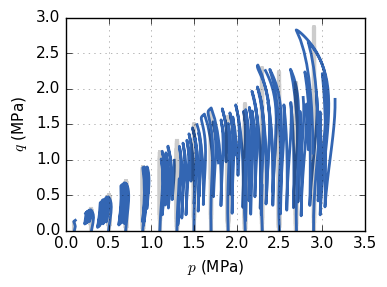

In [25]:
fig = plt.figure(dpi=100, figsize=(4, 3.), tight_layout=True)
ax = fig.subplots(1)
for i in np.arange(sigma.shape[1]):
    ax.plot(y[:,i,0].cpu().detach()/1e+3, y[:,i,1].cpu().detach()/1e+3,
            marker='o',markerfacecolor='white',linestyle='-',
            color='black',alpha=0.2,linewidth=3,markersize=0,label='ref')
    ax.plot(pred_stress[:,i,0]/1e+3, pred_stress[:,i,1]/1e+3,alpha=1,linewidth=2,color=colorb,
        markersize=0,markeredgewidth=0.0,marker='.')
ax.set_ylabel('$q$ (MPa)')
ax.set_xlabel('$p$ (MPa)')
ax.grid()
plt.show()

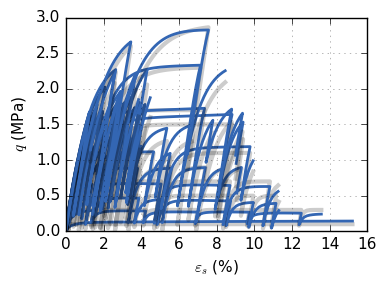

In [26]:
fig = plt.figure(dpi=100, figsize=(4, 3.), tight_layout=True)
ax = fig.subplots(1)
for i in np.arange(sigma.shape[1]):
    ax.plot(strain_t[:,i,1]*1e+5, y[:,i,1].cpu().detach()/1e+3,
            marker='o',markerfacecolor='white',linestyle='-',
            color='black',alpha=0.2,linewidth=3,markersize=0,label='ref')
    ax.plot(strain_t[:,i,1]*1e+5, pred_stress[:,i,1]/1e+3,alpha=1,linewidth=2,color=colorb,
        markersize=0,markeredgewidth=0.0,marker='.')
ax.set_ylabel('$q$ (MPa)')
ax.set_xlabel('$\\varepsilon_s$ (%)')
ax.grid()
plt.show()

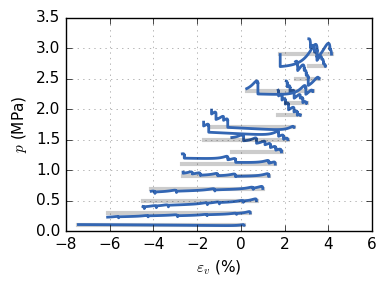

In [27]:
fig = plt.figure(dpi=100, figsize=(4, 3.), tight_layout=True)
ax = fig.subplots(1)
for i in np.arange(sigma.shape[1]):
    ax.plot(strain_t[:,i,0]*1e+5, y[:,i,0].cpu().detach()/1e+3,
            marker='o',markerfacecolor='white',linestyle='-',
            color='black',alpha=0.2,linewidth=3,markersize=0,label='ref')
    ax.plot(strain_t[:,i,0]*1e+5, pred_stress[:,i,0]/1e+3,alpha=1,linewidth=2,color=colorb,
        markersize=0,markeredgewidth=0.0,marker='.')
ax.set_ylabel('$p$ (MPa)')
ax.set_xlabel('$\\varepsilon_v$ (%)')
ax.grid()
plt.show()

### 6. Save model

In [ ]:
PATH = './saved/[state]NICE_benchmark1'
torch.save(NICE_network.state_dict(), PATH)

In [ ]:
with open('./saved/[params]NICE_benchmark1_dense', 'wb') as f_obj:
     pickle.dump(norm_params, f_obj)